# CSC 499 Graphing QUIC vs TCP Simulation Performance

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import numpy as np
import os
import string

In [2]:
dataPathPrefix = os.getcwd() + "\\data\\"

# Three groups of collected data. Benchmarking data is the latest. Others were for
# initial testing.
benchmarkingDataDir = dataPathPrefix + "benchmarking-optimized\\"
quicDataDir = benchmarkingDataDir + "QUIC\\"
tcpDataDir = benchmarkingDataDir + "TCP\\"

# Sample QUIC and TCP runs from the benchmarking data set
sampleQuicDir = benchmarkingDataDir + "QUIC\\festive\\2Mbps\\pacing\\"
sampleTcpDir = benchmarkingDataDir + "TCP\\festive\\2Mbps\\pacing\\"

sampleQuicDirSlow = quicDataDir + "festive\\500Kbps\\no-pacing\\"
sampleTcpDirSlow = tcpDataDir + "festive\\500Kbps\\no-pacing\\"

## Log File Processing
Functions are defined here which can be used to access the data in the log files generated by each simulation run.

In [3]:
""" Return a list containing all fields from the given log file
"""
def readFieldsFromDataFile(filepath):
    lines = []
    with open(filepath) as inFile:
        lines = inFile.readlines()
    
    # Split the lines on whitespace to get the individual fields
    fieldsList = []
    for line in lines:
        fields = line.rstrip('\n').split()
        fieldsList.append(fields)
    
    return fieldsList


def readAdaptationLog(parentDir):       
    filepath = parentDir + "cl0_adaptationLog.txt";
    stringFields = readFieldsFromDataFile(filepath)
    
    headers = stringFields[0][:3]
    
    rows = []
    for row in stringFields[1:]:
        segment = int(row[0])
        qualityLevel = int(row[1])
        timestamp = float(row[2])
        
        rows.append((segment, qualityLevel, timestamp))
    
    return (headers, rows)


def readBufferLog(parentDir):
    filepath = parentDir + "cl0_bufferLog.txt"

    stringFields = readFieldsFromDataFile(filepath)
    
    headers = stringFields[0]
    
    rows = []
    for row in stringFields[1:]:
        timestamp = float(row[0])
        bufferLevel = float(row[1])
        
        rows.append((timestamp, bufferLevel))
    
    return (headers, rows)


def readUnderflowLog(parentDir):   
    filepath = parentDir + "cl0_bufferUnderrunLog.txt"
    stringFields = readFieldsFromDataFile(filepath)
    
    headers = stringFields[0][:3]
    
    rows = []
    for row in stringFields[1:]:
        if len(row) < 2:
            print("Malformed buffer underflow log. Likely that QUIC failed near time {}".format(row[0]))
            break
        
        startTime = float(row[0])
        endTime = float(row[1])
        rows.append((startTime, endTime))

    return (headers, rows)


def readPlaybackLog(parentDir):
    filepath = parentDir + "cl0_playbackLog.txt"
    stringFields = readFieldsFromDataFile(filepath)
    
    headers = stringFields[0][:3]
    
    rows = []
    for row in stringFields[1:]:
        segment = int(row[0])
        startTime = float(row[1])
        qualityLevel = int(row[2])
    
        rows.append((segment, startTime, qualityLevel))
    
    return (headers, rows)


def readDownloadLog(parentDir):
    filepath = parentDir + "cl0_downloadLog.txt"
    stringFields = readFieldsFromDataFile(filepath)
    
    headers = stringFields[0][:3]
    
    rows = []
    for row in stringFields[1:]:
        segment = int(row[0])
        startTime = float(row[2])
        endTime = float(row[3])
        segmentSize = int(row[4])
    
        rows.append((segment, startTime, endTime, segmentSize))
    
    return (headers, rows)


def readThroughputLog(parentDir):
    filepath = parentDir + "cl0_throughputLog.txt"
    stringFields = readFieldsFromDataFile(filepath)
    
    # Since these files are so big, we depart from the existing pattern.
    # 1. Ignore the headers
    # 2. Create separate arrays of the two values we care about and return them.
    
    rowCount = len(stringFields) - 1
    times = np.empty(rowCount)
    sizes = np.empty(rowCount)
    i = 0
    for row in stringFields[1:]:
        times[i] = float(row[0])
        sizes[i] = int(row[1])
        i += 1

    return (times, sizes)

## Quality Level Graphing
Helper functions are provided that graph single simulations' quality progressions and that provide a comparison graph of two simulations.

In [4]:
###
# Helper functions
###


# Helper function to get x and y data for graphing
def getQualityData(parentDir):
    (adaptHeaders, adaptData) = readAdaptationLog(parentDir)
    
    # Pull out the two columns we care about as np arrays
    npAdaptData = np.array(adaptData)
    adaptSegments = npAdaptData[:,0]
    adaptQuality = npAdaptData[:,1]
    
    return (adaptSegments, adaptQuality)


def setIntegerYTickInterval(ax):
    # https://stackoverflow.com/questions/27496737/how-to-force-matplotlib-to-display-only-whole-numbers-on-the-y-axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


# Helper function to get x and y data when graphing TCP and QUIC comparison plots
def getQualityComparisonData(quicDir, tcpDir):
    segments, quicQuality = getQualityData(quicDir)
    _, tcpQuality = getQualityData(tcpDir)
    
    # Shorten the tcp data to the length of the quic data
    quicCount = len(segments)
    tcpQuality = tcpQuality[:quicCount]
    
    return (segments, quicQuality, tcpQuality)

In [5]:
'''Graphs segment qualities over time

parentDir is the directory containing the log files for the simulation run in question.
'''
def graphAdaptationLevel(parentDir):
    segments, quality = getQualityData(parentDir)    
    
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)

    plt.xlabel("Video Segment")
    plt.ylabel("Quality Level")
    
    # Set the tick distribution for quality axis
    setIntegerYTickInterval(ax)

    # Set the tick distribution for x axis to every 10th segment
    maxSegment = segments[-1]
    xTickMax = (maxSegment/10) * 10 + 10
    plt.xticks(np.arange(0, xTickMax, 10))

    ax.plot(segments, quality, "o")


''' Graph the adaptation levels for the QUIC and TCP simulations on one figure
'''
def compareAdaptationLevelsOverlay(quicDir, tcpDir):
    segments, quicQuality, tcpQuality = getQualityComparisonData(quicDir, tcpDir)
    
    # Plot the QUIC and TCP qualities along the same axis   
    fig = plt.figure(figsize=(15, 3))
    ax = fig.add_subplot(111)
    
    setIntegerYTickInterval(ax)
    
    ax.plot(segments, quicQuality, 'bx', label="QUIC")
    ax.plot(segments, tcpQuality, 'g+', label="TCP")

    plt.xlabel("Video Segment")
    plt.ylabel("Quality Level")
    
    plt.legend()
    plt.show()


''' Graph the adaptation levels for the QUIC and TCP simulations side-by-side
'''
def compareAdaptationLevelsSeparate(quicDir, tcpDir):
    segments, quicQuality, tcpQuality = getQualityComparisonData(quicDir, tcpDir)
    
    # Plot the QUIC and TCP qualities in separate figures   
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(15, 3))

    ax1.set_title("QUIC")
    ax2.set_title("TCP")
    
    # Turn on the TCP plot's tick labels manually. They've been turned of by
    # sharing the axis between subplots.
    ax2.yaxis.set_tick_params(labelleft=True)
    
    # Enforce integer values for y axis ticks
    setIntegerYTickInterval(ax1)
    setIntegerYTickInterval(ax2)
    
    ax1.plot(segments, quicQuality, 'bo', label="QUIC")
    ax2.plot(segments, tcpQuality, 'go', label="TCP")

    ax1.set_xlabel("Video Segment")
    ax2.set_xlabel("Video Segment")
    ax1.set_ylabel("Quality Level")
    ax2.set_ylabel("Quality Level")
    
    plt.show()

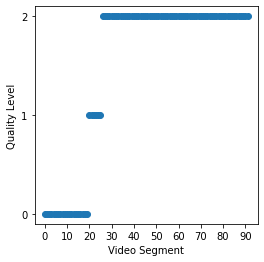

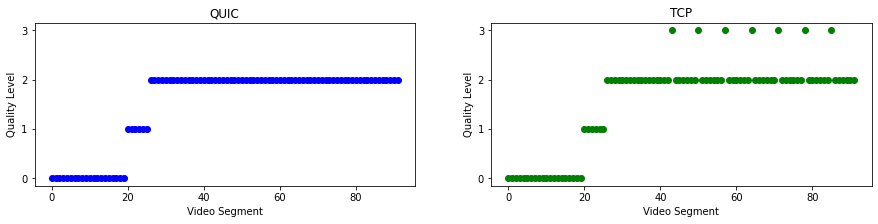

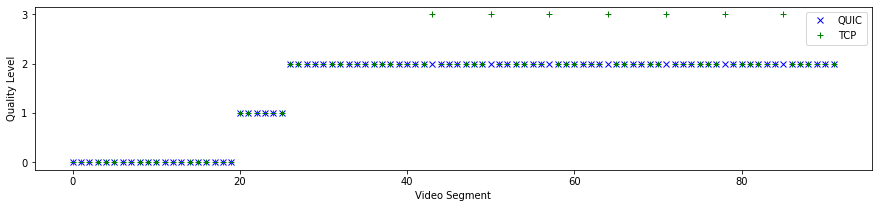

In [6]:
# Show how we can use the above functions to graph quality data
graphAdaptationLevel(sampleQuicDir)
compareAdaptationLevelsSeparate(sampleQuicDir, sampleTcpDir)
compareAdaptationLevelsOverlay(sampleQuicDir, sampleTcpDir)

## Buffer Level Graphing
Graphing functions that let us visualize the buffer level of the client during streaming

In [7]:
###
# Helper Functions
###

def getBufferData(parentDir):
    # Ignore headers
    (_, bufferData) = readBufferLog(parentDir) 

    # Split out the columns
    npBufferData = np.array(bufferData)
    timestamps = npBufferData[:,0]
    levels = npBufferData[:,1]

    return (timestamps, levels)


def getBufferComparisonData(quicDir, tcpDir):
    quicTs, quicLvls = getBufferData(quicDir)
    tcpTs, tcpLvls = getBufferData(tcpDir)
    
    # Remove the timestamps from the TCP run that go past where QUIC stopped.
    quicEndTs = quicTs[-1]
    tcpQuicEndIndex = np.argmax(tcpTs > quicEndTs)
    tcpTs = tcpTs[:tcpQuicEndIndex]
    tcpLvls = tcpLvls[:tcpQuicEndIndex]
    
    return (quicTs, tcpTs, quicLvls, tcpLvls)

In [8]:
'''Graph the client buffer level over time'''
def graphBufferLevel(parentDir):
    times, levels = getBufferData(parentDir)
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Buffer level (segments)")
    
    ax.plot(times, levels)
    
    plt.show()

def graphBufferLevelComparison(quicDir, tcpDir):
    buffData = getBufferComparisonData(quicDir, tcpDir)
    quicTimes, tcpTimes, quicLevels, tcpLevels = buffData
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    
    plt.xlabel("Time (seconds)")
    plt.ylabel("Buffer level (segments)")
    
    ax.plot(quicTimes, quicLevels, label="QUIC")
    ax.plot(tcpTimes, tcpLevels, label="TCP")
    
    plt.legend()
    plt.show()

QUIC buffer graph


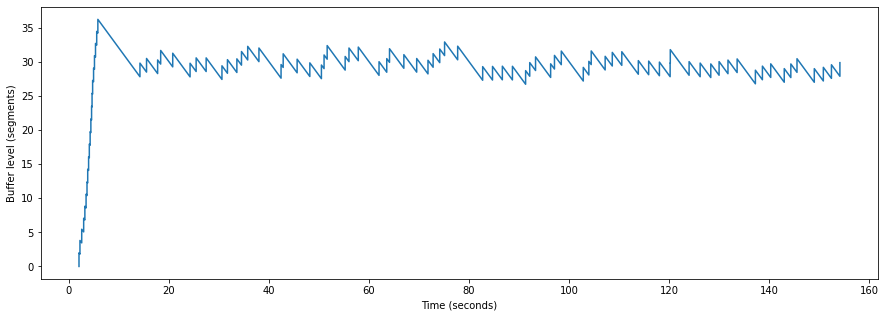

TCP buffer graph


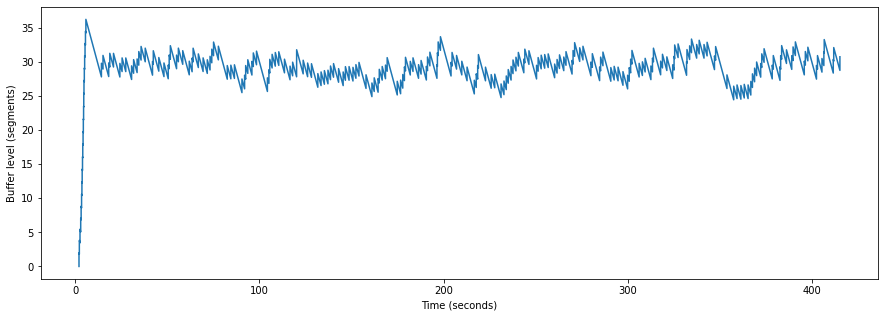

Comparison graph 1


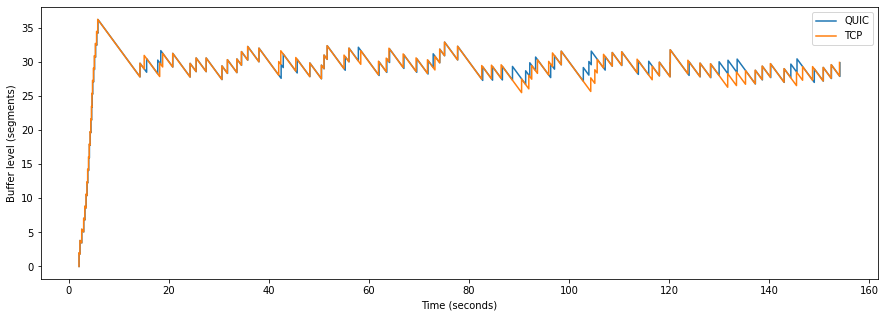

Comparison graph 2


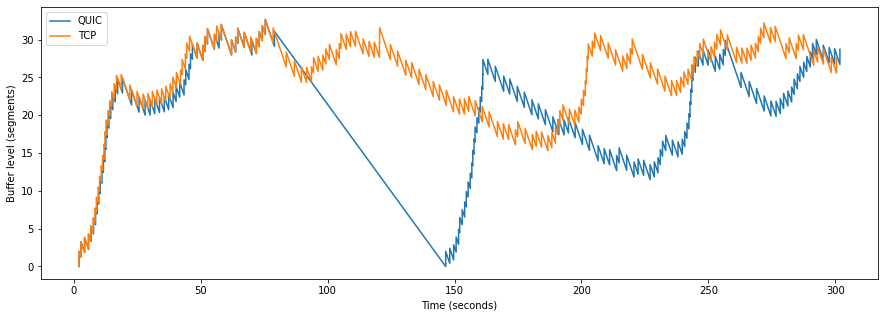

In [9]:
print ("QUIC buffer graph")
graphBufferLevel(sampleQuicDir)

print ("TCP buffer graph")
graphBufferLevel(sampleTcpDir)

print ("Comparison graph 1")
graphBufferLevelComparison(sampleQuicDir, sampleTcpDir)

print ("Comparison graph 2")
graphBufferLevelComparison(sampleQuicDirSlow, sampleTcpDirSlow)

## Timeline Graphing
Vertically stacked graphs of many of the observable parameters recorded in the log files, all sharing a common axis.
This is useful for debugging and visualizing system behaviour.

In [10]:
###
# Helper Functions
###
def getUnderflowTimes(parentDir):
    (_, intervals) = readUnderflowLog(parentDir)
    return intervals


def getPlaybackData(parentDir):
    _, playbackRows = readPlaybackLog(parentDir)

    npData = np.array(playbackRows)
    segments = npData[:,0]
    playbackTimes = npData[:,1]
    qualityLevels = npData[:,2]
    
    return (segments, playbackTimes, qualityLevels)


def getDownloadData(parentDir):
    _, downloadRows = readDownloadLog(parentDir)
    
    npData = np.array(downloadRows)
    segments = npData[:,0]
    startTimes = npData[:,1]
    endTimes = npData[:,2]
    sizes = npData[:,3]
    
    return (startTimes, endTimes, sizes)

In [11]:
def graphBufferWithUnderflow(parentDir):
    times, levels = getBufferData(parentDir)
    underflowTimes = getUnderflowTimes(parentDir)
    
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Buffer level (segments)")
    
    ax.plot(times, levels, label="Buffer Level")
    
    # Add underflow lines to legend
    handles, labels = ax.get_legend_handles_labels()
    redLine = Line2D([0], [0], label='Underflow Detected', color='r')
    greenLine = Line2D([0], [0], label="Underflow Resolved", color ='g')    
    handles.extend([redLine, greenLine])
    
    # Mark underflows with vertical lines
    for (start, end) in underflowTimes:        
        plt.axvline(x=start, color="r")
        plt.axvline(x=end, color="g")

    plt.legend(handles=handles)
    plt.show()
    

def graphFullTimeline(parentDir):
    bufferTimes, bufferLevels = getBufferData(parentDir)
    underflowTimes = getUnderflowTimes(parentDir)
    segments, playbackTimes, quality = getPlaybackData(parentDir)
    startTimes, endTimes, segmentSizes = getDownloadData(parentDir)
    downloadTimes, downloadSizes = readThroughputLog(parentDir)
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex='col', figsize=(15, 12))

    # Buffer level plot (ax1)
    ax1.set_title("Buffer Level")   
    ax1.set_ylabel("Buffer level (segments)")
    
    ax1.plot(bufferTimes, bufferLevels, label="Buffer Level")
    
    # Add underflow lines to legend
    handles, labels = ax1.get_legend_handles_labels()
    redLine = Line2D([0], [0], label='Underflow Detected', color='r')
    greenLine = Line2D([0], [0], label="Underflow Resolved", color ='g')    
    handles.extend([redLine, greenLine])
    
    # Mark underflows with vertical lines
    for (start, end) in underflowTimes:        
        ax1.axvline(x=start, color="r")
        ax1.axvline(x=end, color="g")

    ax1.legend()

    # Playback quality plot (ax2)
    ax2.set_title("Playback Quality Levels")        
    ax2.set_ylabel("Playback quality level")
    setIntegerYTickInterval(ax2)
    
    ax2.plot(playbackTimes, quality, "o")
        
    # Download size plot (ax3)
    ax3.set_title("Segment Downloads")
    ax3.set_ylabel("Segment Download Size (bytes)")
    
    tickOffset = max(segmentSizes) / 80.0
    for segment in range (len(segments)):
        size = segmentSizes[segment]
        start = startTimes[segment]
        end = endTimes[segment]
        
        ax3.hlines(y=size, xmin=start, xmax=end, linewidth=1)
        ax3.vlines(x=start, ymin=size-tickOffset, ymax=size+tickOffset, linewidth=1)
        ax3.vlines(x=end, ymin=size-tickOffset, ymax=size+tickOffset, linewidth=1)
    
    # Throughput plot (ax4)
    ax4.set_title("Throughput (data received by client)")
    ax4.set_ylabel("Datagram Size (Bytes)")
    
    ax4.scatter(downloadTimes, downloadSizes, s=1)
    
    # Average Throughput plot (ax5)
    ax5.set_title("Data received each second")
    ax5.set_xlabel("Time (seconds)")    
    ax5.set_ylabel("Data Received (bytes)")    
    
    # Build up a bucket for each second
    maxWholeSecond = int(np.floor(downloadTimes[-1]))
    avgThroughputBars = np.zeros(maxWholeSecond + 1)
    for (time, size) in zip(downloadTimes, downloadSizes):
        bucket = int(np.floor(time))
        avgThroughputBars[bucket] += size

    ax5.bar(np.arange(len(avgThroughputBars)), avgThroughputBars)
        
    plt.show()

Malformed buffer underflow log. Likely that QUIC failed near time 330.524


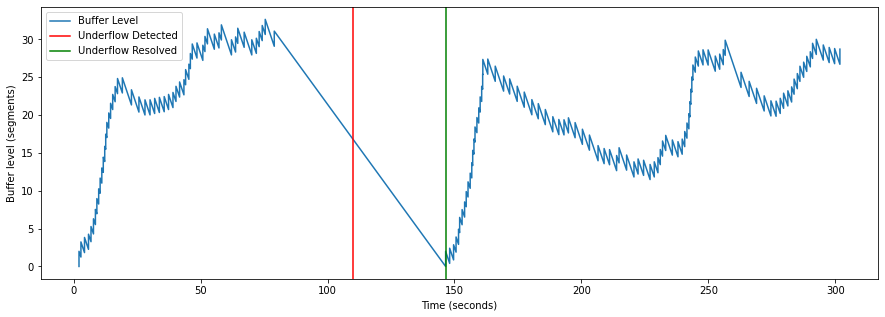

In [12]:
# Show how we can graph with underflow annotations
graphBufferWithUnderflow(sampleQuicDirSlow)

QUIC 500Kbps
Malformed buffer underflow log. Likely that QUIC failed near time 330.524


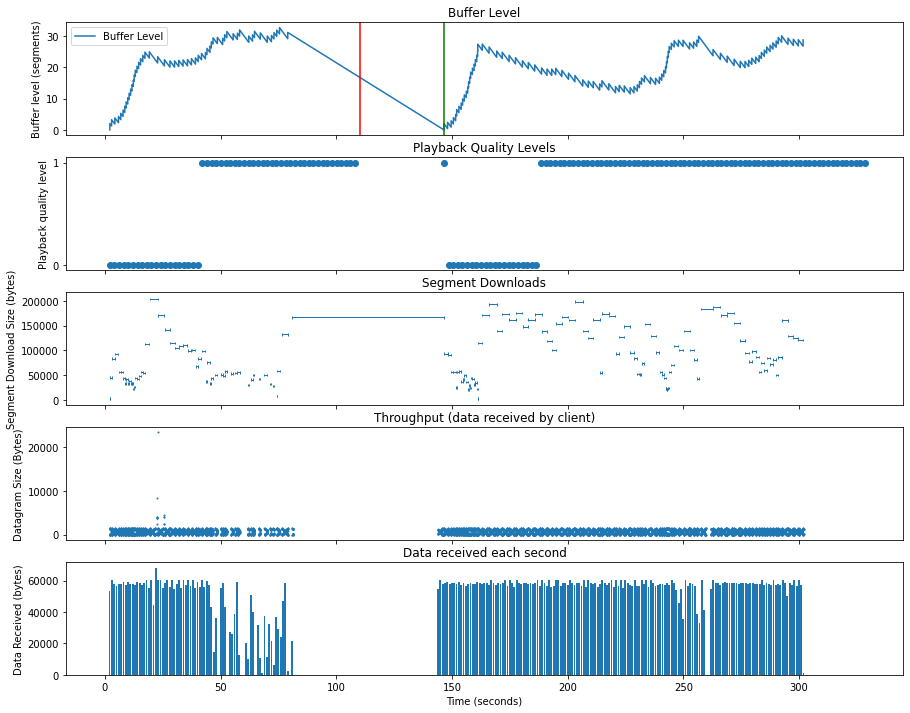

TCP 500Kbps


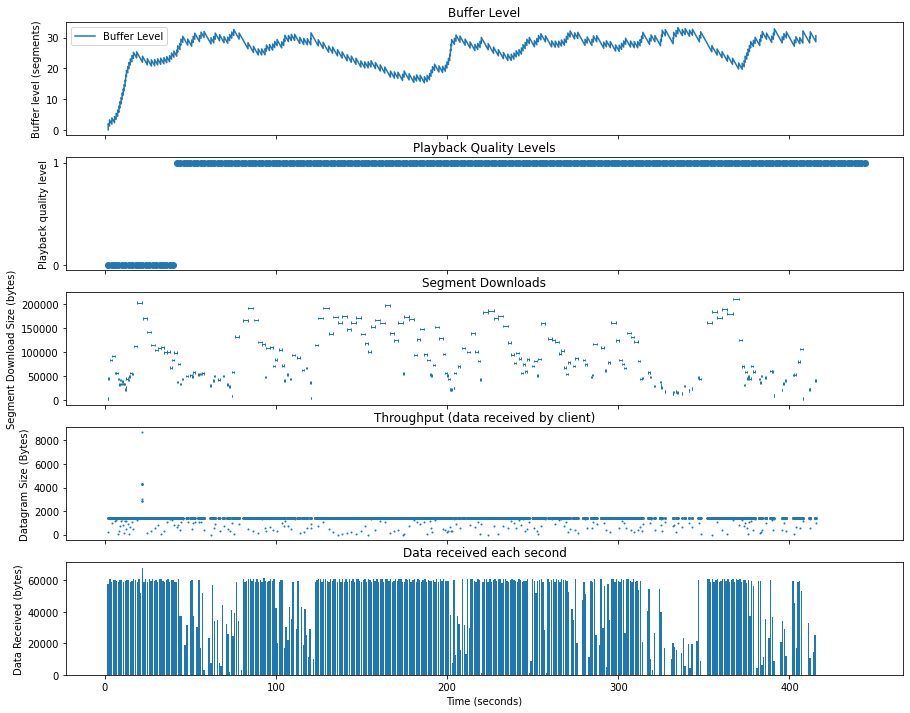

In [13]:
# Show the full timeline graphs
print ("QUIC 500Kbps")
graphFullTimeline(sampleQuicDirSlow)

print ("TCP 500Kbps")
graphFullTimeline(sampleTcpDirSlow)

QUIC 2Mbps
Malformed buffer underflow log. Likely that QUIC failed near time 184.045


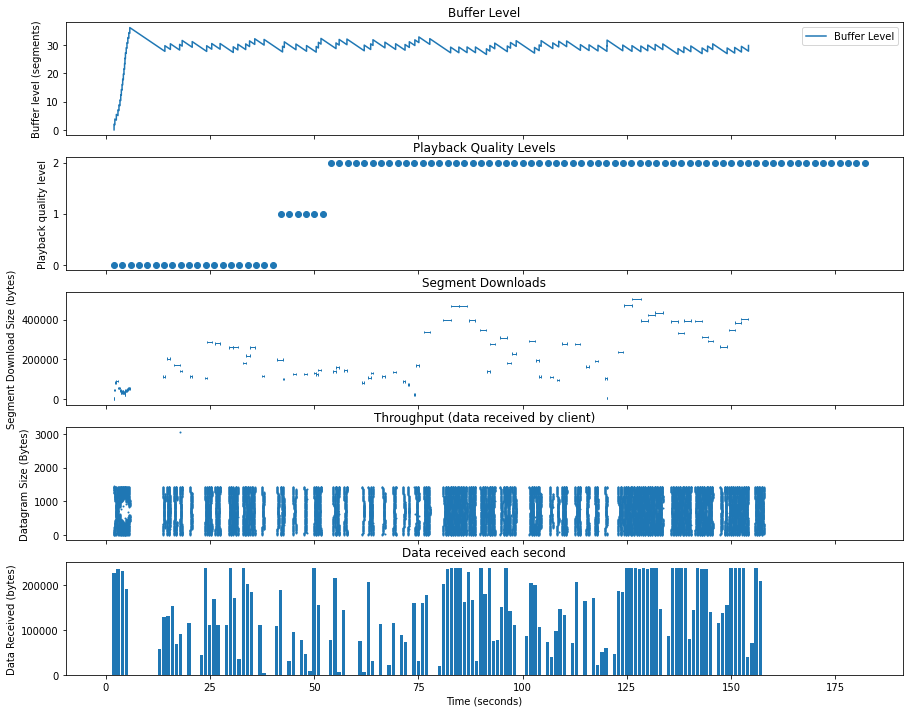

In [14]:
print ("QUIC 2Mbps")
graphFullTimeline(sampleQuicDir)

## Numerical Computations

In [15]:
###
# Helper Functions
###

def getQualityLevels(parentDir):
    _, rows = readAdaptationLog(parentDir)
    return np.array(rows)[:,1] 

In [16]:
''' Computes the mean quality level over all segments
'''
def averageQualityLevel(parentDir):
    qualities = getQualityLevels(parentDir)
    return np.mean(qualities)

''' Computes the number of times a buffer underflow ocurred
'''
def underflowCount(parentDir):
    _, rows = readUnderflowLog(parentDir)
    return len(rows)

''' Computes the number of times the quality level changed during streaming
'''
def qualityChangeCount(parentDir):
    qualities = getQualityLevels(parentDir)
    changeCount = 0
    current = qualities[0]
    for quality in qualities[1:]:
        if current != quality:
            current = quality
            changeCount += 1
    
    return changeCount

In [17]:
print ("Average Quality Level - QUIC 500Kbps: ", averageQualityLevel(sampleQuicDirSlow))
print ("Average Quality Level - TCP  500Kbps: ", averageQualityLevel(sampleTcpDirSlow))
print ("Average Quality Level - QUIC 1Mbps:   ", averageQualityLevel(sampleQuicDir))
print ("Average Quality Level - TCP  1Mbps:   ", averageQualityLevel(sampleTcpDir))

Average Quality Level - QUIC 500Kbps:  0.7278911564625851
Average Quality Level - TCP  500Kbps:  0.9099099099099099
Average Quality Level - QUIC 1Mbps:    1.5
Average Quality Level - TCP  1Mbps:    1.90990990990991


In [18]:
print ("Number of buffer under-runs - QUIC 500Kbps: ", underflowCount(sampleQuicDirSlow))
print ("Number of buffer under-runs - TCP  500Kbps: ", underflowCount(sampleTcpDirSlow))
print ("Number of buffer under-runs - QUIC 1Mbps:   ", underflowCount(sampleQuicDir))
print ("Number of buffer under-runs - TCP  1Mbps:   ", underflowCount(sampleTcpDir))

Malformed buffer underflow log. Likely that QUIC failed near time 330.524
Number of buffer under-runs - QUIC 500Kbps:  1
Number of buffer under-runs - TCP  500Kbps:  0
Malformed buffer underflow log. Likely that QUIC failed near time 184.045
Number of buffer under-runs - QUIC 1Mbps:    0
Number of buffer under-runs - TCP  1Mbps:    0


In [19]:
print ("Number of quality changes - QUIC 500Kbps: ", qualityChangeCount(sampleQuicDirSlow))
print ("Number of quality changes - TCP  500Kbps: ", qualityChangeCount(sampleTcpDirSlow))
print ("Number of quality changes - QUIC 1Mbps:   ", qualityChangeCount(sampleQuicDir))
print ("Number of quality changes - TCP  1Mbps:   ", qualityChangeCount(sampleTcpDir))

Number of quality changes - QUIC 500Kbps:  3
Number of quality changes - TCP  500Kbps:  1
Number of quality changes - QUIC 1Mbps:    2
Number of quality changes - TCP  1Mbps:    54


## Bulk Data Visualization
Some initial graphs of the QUIC simulations which are not crashing until after a given threshold (e.g. 90 segments/180 seconds) and the corresponding sections of the related TCP simulations. 

In [20]:
# Helper functions

def countSegmentsDownloaded(parentDir):
    _, rows = readDownloadLog(parentDir)
    return len(rows)


def isSimulationDirectory(parentDir, files):
    # Assume that if one log file exists, so do the others
    return "cl0_adaptationLog.txt" in files


# https://stackoverflow.com/questions/2556108/rreplace-how-to-replace-the-last-occurrence-of-an-expression-in-a-string
def rreplace(s, old, new):
    li = s.rsplit(old, 1)
    return new.join(li)


def getMultiplier(s):
    titleCaseString = s[0].upper() + s[1:].lower()
    if titleCaseString == 'Kbps':
        return 1000
    elif titleCaseString == 'Mbps':
        return 1000000
    elif titleCaseString == 'Gbps':
        return 1000000000

    assert False # Unsupported prefix

def getRateInBytes(rateString):
    numericPart = rateString.strip(string.ascii_letters)
    unitPart = rateString.strip(string.digits)
    
    assert rateString == numericPart + unitPart
    
    return int(numericPart) * getMultiplier(unitPart)


def getConfigFromPath(path):
    # Strip off the common prefix
    prefix = benchmarkingDataDir
    assert path.startswith(prefix)

    prefixLength = len(prefix)
    noPrefix = path[prefixLength:]
    
    # Each directory level gives one part of the configuration. 
    # Split the path and format appropriately.
    (proto, algo, rate, pacing, _) = noPrefix.split('\\') # Ignore trailing empty string
    
    rateNumber = getRateInBytes(rate)
    pacingBool = pacing == 'pacing' 
    return (proto, algo, rateNumber, pacingBool)


def compareSimulations(sim1Dir, sim2Dir):
    # Split the paths into their component parts. Ignore trailing empty
    # string from trailing '\' character
    (proto1, algo1, rate1, pacing1) = getConfigFromPath(sim1Dir)
    (proto2, algo2, rate2, pacing2) = getConfigFromPath(sim2Dir)

    if proto1 < proto2:
        return -1
    elif proto2 < proto1:
        return 1
    
    if algo1 < algo2:
        return -1
    elif algo2 < algo1:
        return 1
    
    if (rate1 != rate2):
        return rate1 - rate2
    
    if pacing1 == pacing2:
        return 0
    elif pacing1:
        return 1
    else:
        return -1

In [21]:
# https://docs.python.org/3/howto/sorting.html
def cmp_to_key(mycmp):
    'Convert a cmp= function into a key= function'
    class K:
        def __init__(self, obj, *args):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0
        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0
        def __ne__(self, other):
            return mycmp(self.obj, other.obj) != 0
    return K


# Logic to find the QUIC simulations which ran for a sufficient amount of time.
def findSimulations(minSegmentCount = 90, topDir = quicDataDir):
    simulations = []
    for path, subdirs, files in os.walk(topDir):
        pathWithTrailingSep = path + '\\'
        if isSimulationDirectory(pathWithTrailingSep, files):
            numSegments = countSegmentsDownloaded(pathWithTrailingSep)
            if (numSegments >= minSegmentCount):
                simulations.append(pathWithTrailingSep)
    
    return sorted(simulations, key=cmp_to_key(compareSimulations))


# Convert QUIC path to TCP path for same simulation config
def findTcpAnalog(quicDir):
    return rreplace(quicDir, "QUIC", "TCP")


def findSimulationPairs(minSegmentCount = 90, topDir = quicDataDir):
    quicDirs = findSimulations(minSegmentCount, topDir)
    return [(quicDir, findTcpAnalog(quicDir)) for quicDir in quicDirs]

In [22]:
# Logic to format a file path into a nicer title string
def getSimulationTitle(simulationDir):
    # Strip off the common prefix
    prefixLength = len(benchmarkingDataDir)
    noPrefix = simulationDir[prefixLength:]
    
    # Each directory level gives one part of the configuration. 
    # Split the path and format appropriately.
    (proto, algo, rate, pacing, _) = noPrefix.split('\\') # Ignore trailing empty string
    pacingStr = 'with pacing' if pacing == 'pacing' else "without pacing"
    
    return "{} over {} @ {} ({})".format(algo, proto, rate, pacingStr)

In [23]:
print ("Success w.r.t default threshold")
for path in findSimulations():
    print ('\t', getSimulationTitle(path))

print ("\nSuccess w.r.t custom threshold (tobasco only)")
for path in findSimulations(50, quicDataDir + "tobasco\\"):
    print ('\t', getSimulationTitle(path))

Success w.r.t default threshold
	 festive over QUIC @ 500Kbps (without pacing)
	 festive over QUIC @ 500Kbps (with pacing)
	 festive over QUIC @ 1Mbps (with pacing)
	 festive over QUIC @ 2Mbps (without pacing)
	 festive over QUIC @ 2Mbps (with pacing)
	 tobasco over QUIC @ 500Kbps (without pacing)
	 tobasco over QUIC @ 500Kbps (with pacing)
	 tobasco over QUIC @ 1Mbps (without pacing)
	 tobasco over QUIC @ 2Mbps (with pacing)
	 tobasco over QUIC @ 3Mbps (without pacing)
	 tobasco over QUIC @ 3Mbps (with pacing)
	 tobasco over QUIC @ 4Mbps (without pacing)

Success w.r.t custom threshold (tobasco only)
	 tobasco over QUIC @ 100Kbps (without pacing)
	 tobasco over QUIC @ 100Kbps (with pacing)
	 tobasco over QUIC @ 500Kbps (without pacing)
	 tobasco over QUIC @ 500Kbps (with pacing)
	 tobasco over QUIC @ 1Mbps (without pacing)
	 tobasco over QUIC @ 1Mbps (with pacing)
	 tobasco over QUIC @ 2Mbps (with pacing)
	 tobasco over QUIC @ 3Mbps (without pacing)
	 tobasco over QUIC @ 3Mbps (with p

festive over QUIC @ 500Kbps (without pacing)  vs.  festive over TCP @ 500Kbps (without pacing)


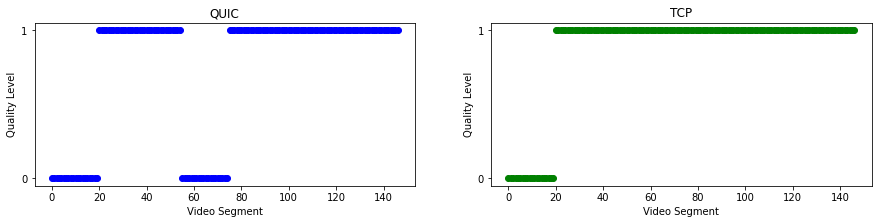

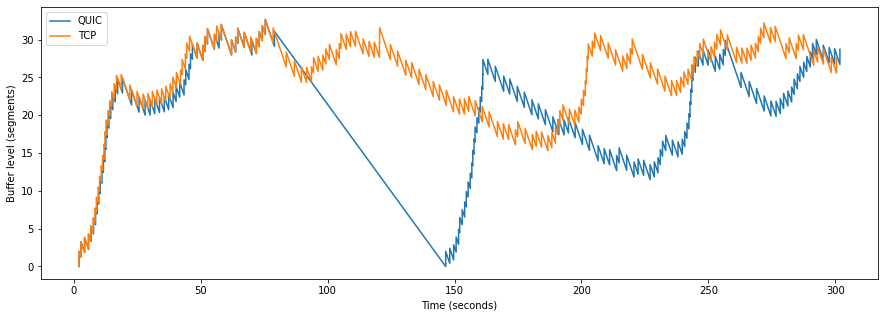

festive over QUIC @ 500Kbps (with pacing)  vs.  festive over TCP @ 500Kbps (with pacing)


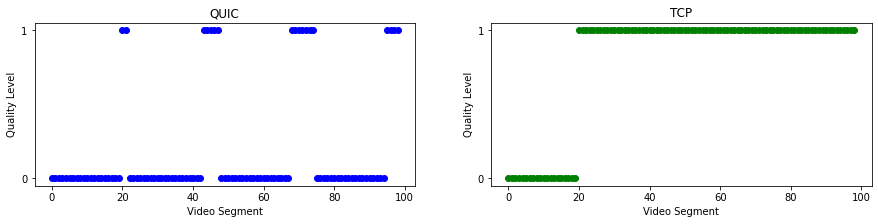

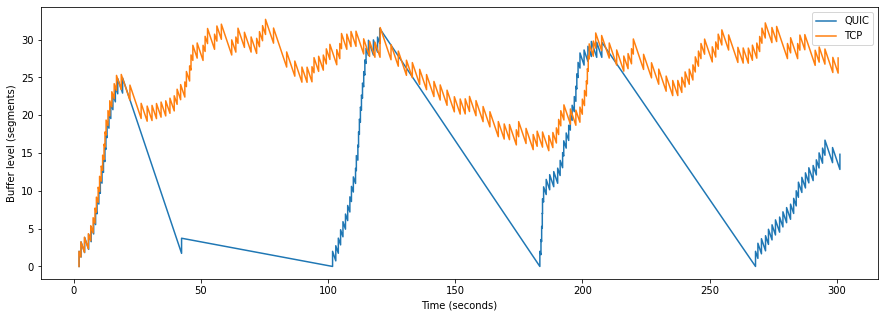

festive over QUIC @ 1Mbps (with pacing)  vs.  festive over TCP @ 1Mbps (with pacing)


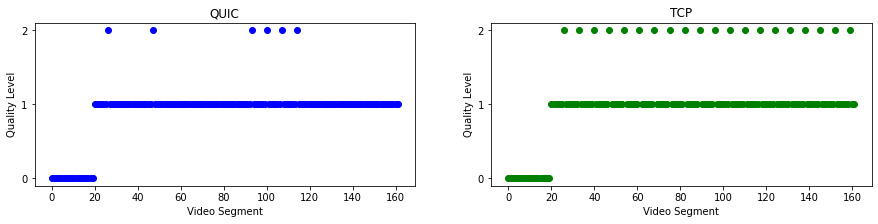

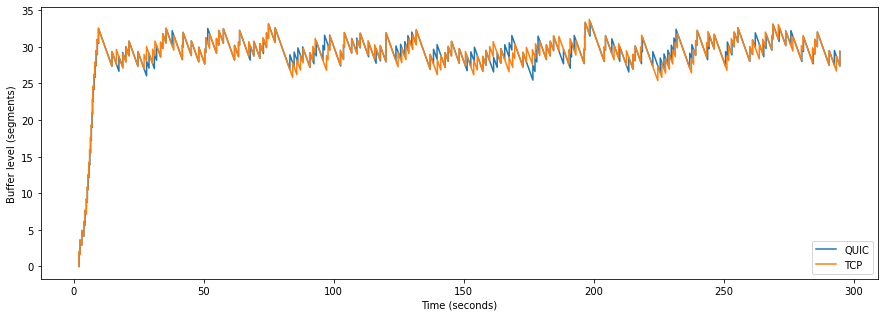

festive over QUIC @ 2Mbps (without pacing)  vs.  festive over TCP @ 2Mbps (without pacing)


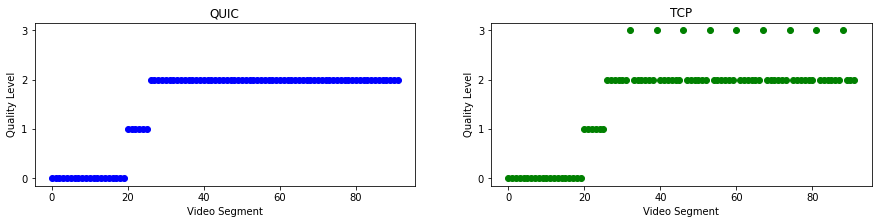

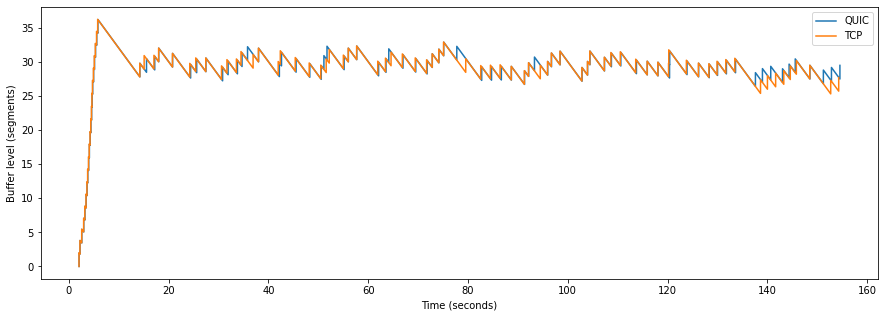

festive over QUIC @ 2Mbps (with pacing)  vs.  festive over TCP @ 2Mbps (with pacing)


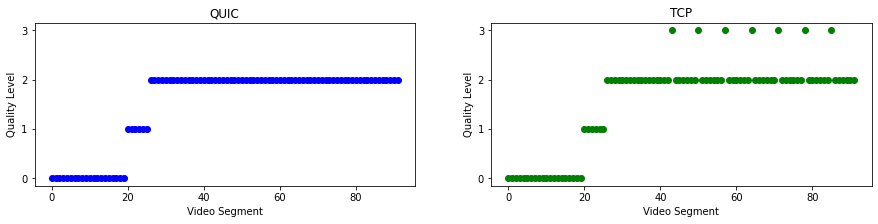

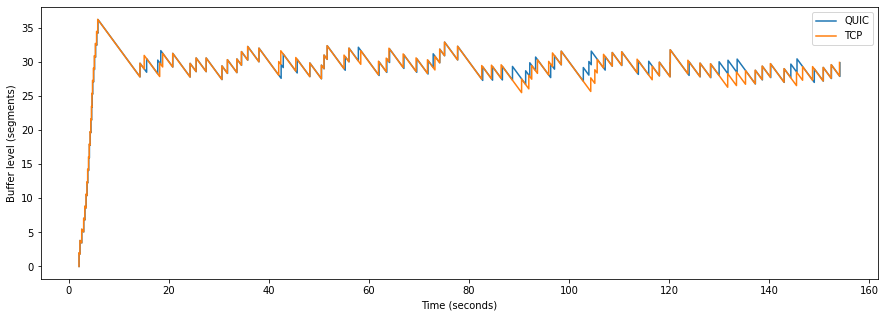

tobasco over QUIC @ 500Kbps (without pacing)  vs.  tobasco over TCP @ 500Kbps (without pacing)


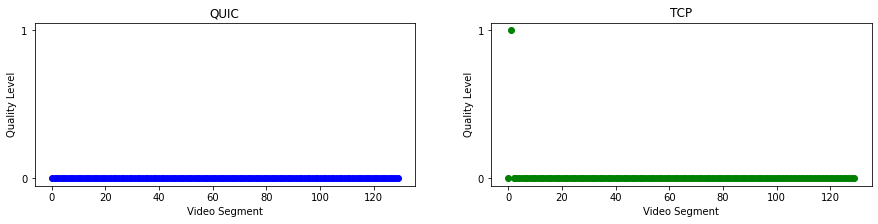

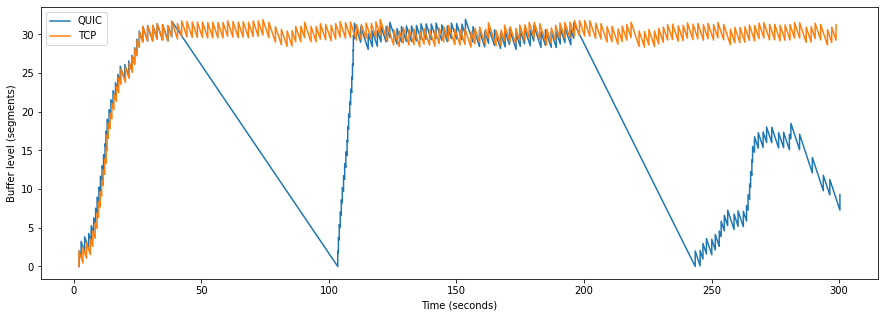

tobasco over QUIC @ 500Kbps (with pacing)  vs.  tobasco over TCP @ 500Kbps (with pacing)


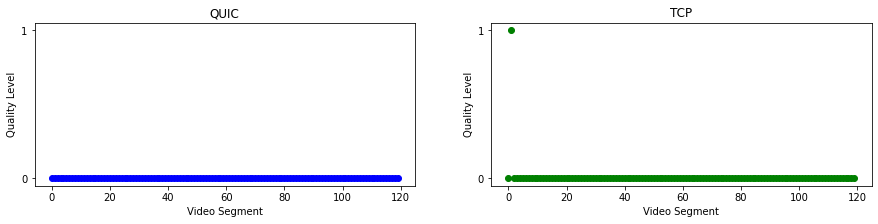

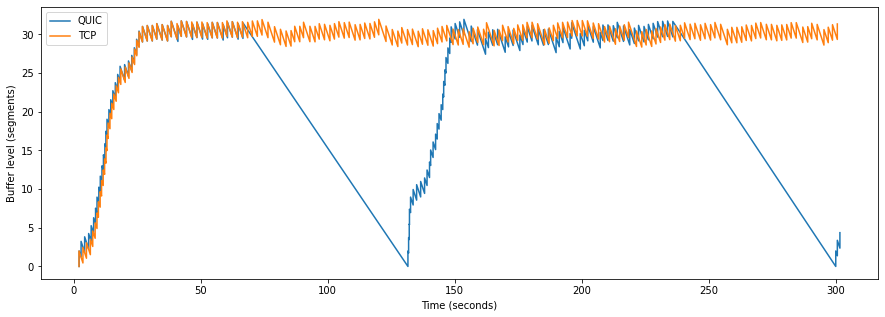

tobasco over QUIC @ 1Mbps (without pacing)  vs.  tobasco over TCP @ 1Mbps (without pacing)


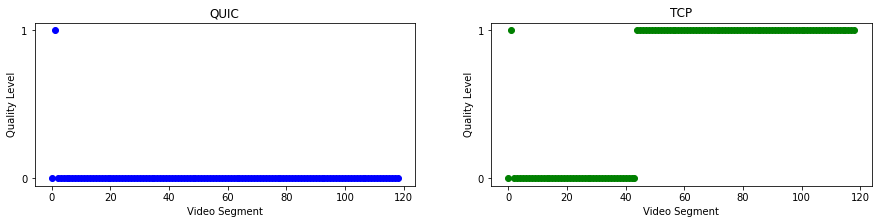

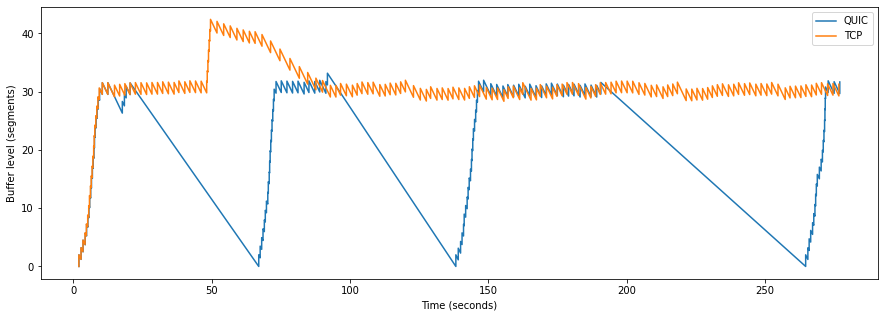

tobasco over QUIC @ 2Mbps (with pacing)  vs.  tobasco over TCP @ 2Mbps (with pacing)


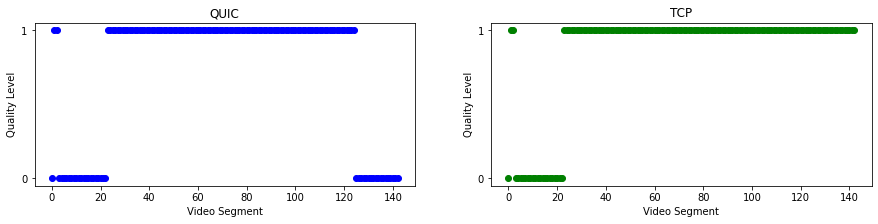

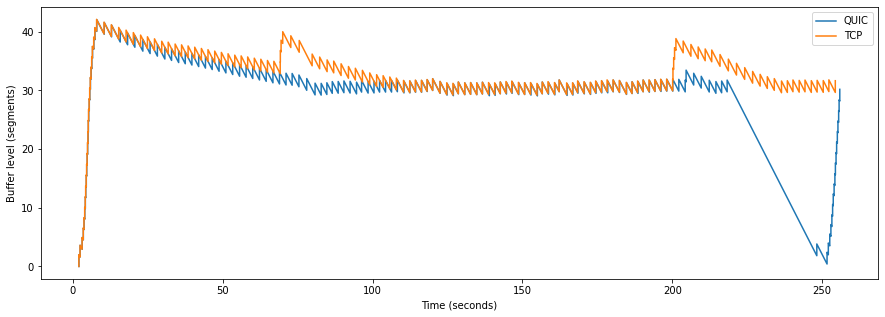

tobasco over QUIC @ 3Mbps (without pacing)  vs.  tobasco over TCP @ 3Mbps (without pacing)


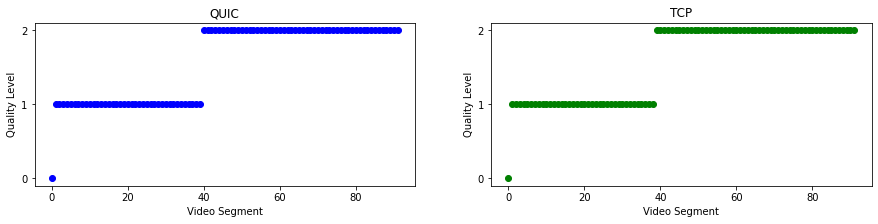

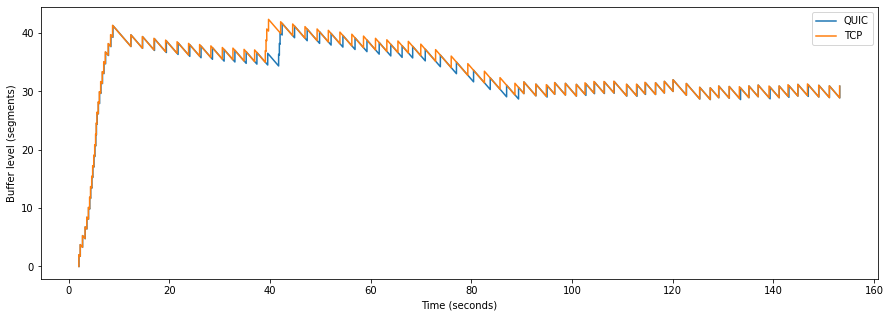

tobasco over QUIC @ 3Mbps (with pacing)  vs.  tobasco over TCP @ 3Mbps (with pacing)


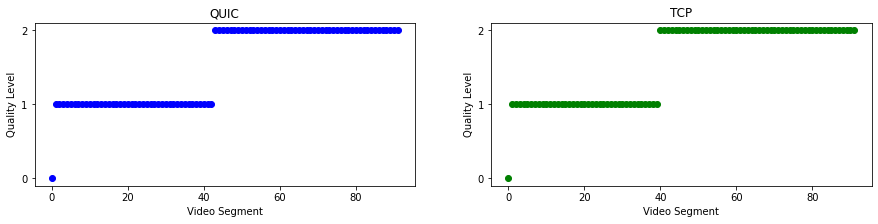

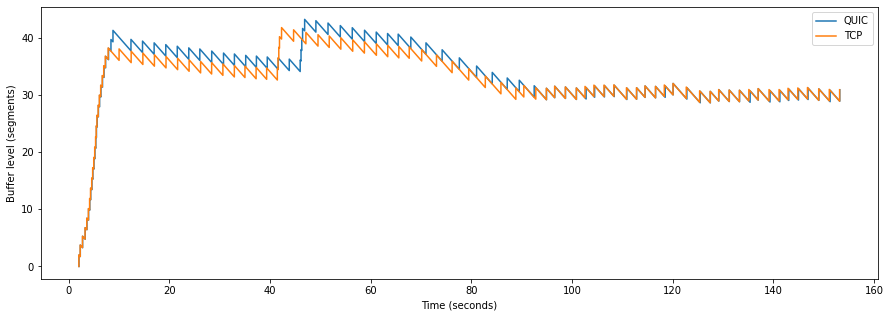

tobasco over QUIC @ 4Mbps (without pacing)  vs.  tobasco over TCP @ 4Mbps (without pacing)


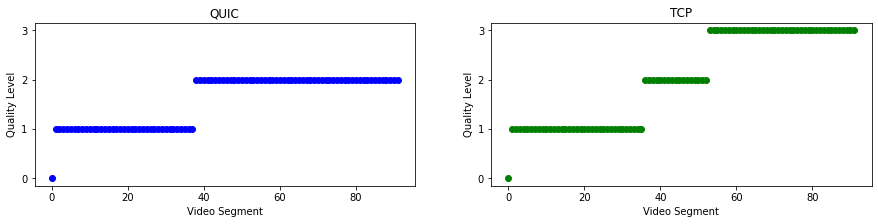

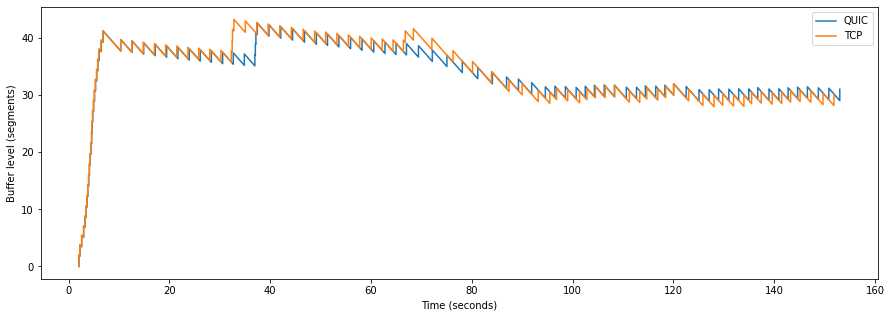

In [24]:
# Compare all the quality and buffer levels
for (quicPath, tcpPath) in findSimulationPairs():
    quicTitle = getSimulationTitle(quicPath)
    tcpTitle = getSimulationTitle(tcpPath)
    
    print (quicTitle, " vs. ", tcpTitle)
    compareAdaptationLevelsSeparate (quicPath, tcpPath)
    graphBufferLevelComparison(quicPath, tcpPath)

festive over QUIC @ 500Kbps (without pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 330.524


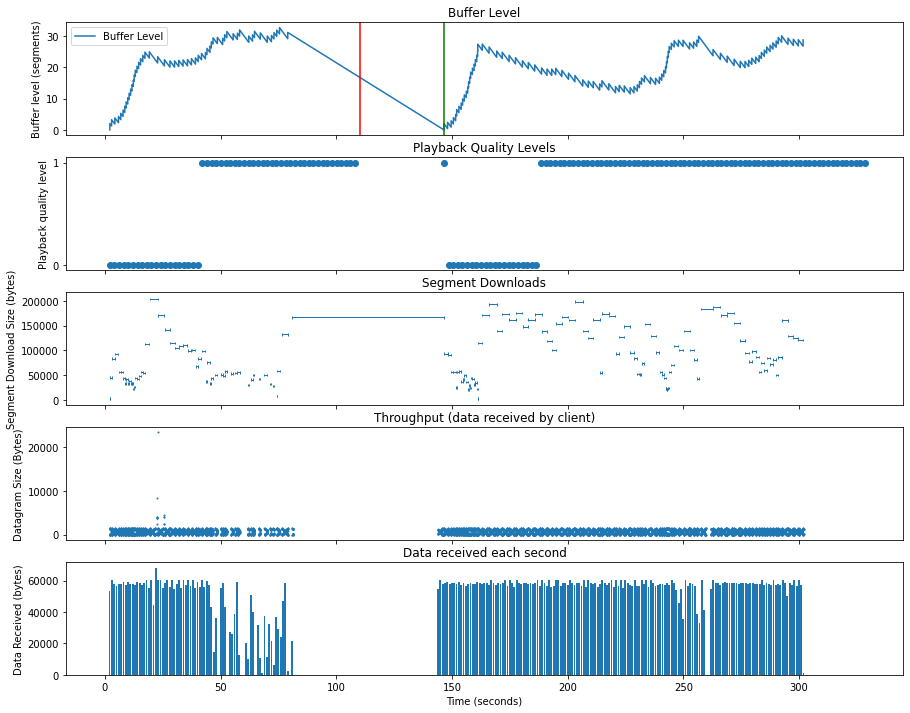



festive over QUIC @ 500Kbps (with pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 316.032


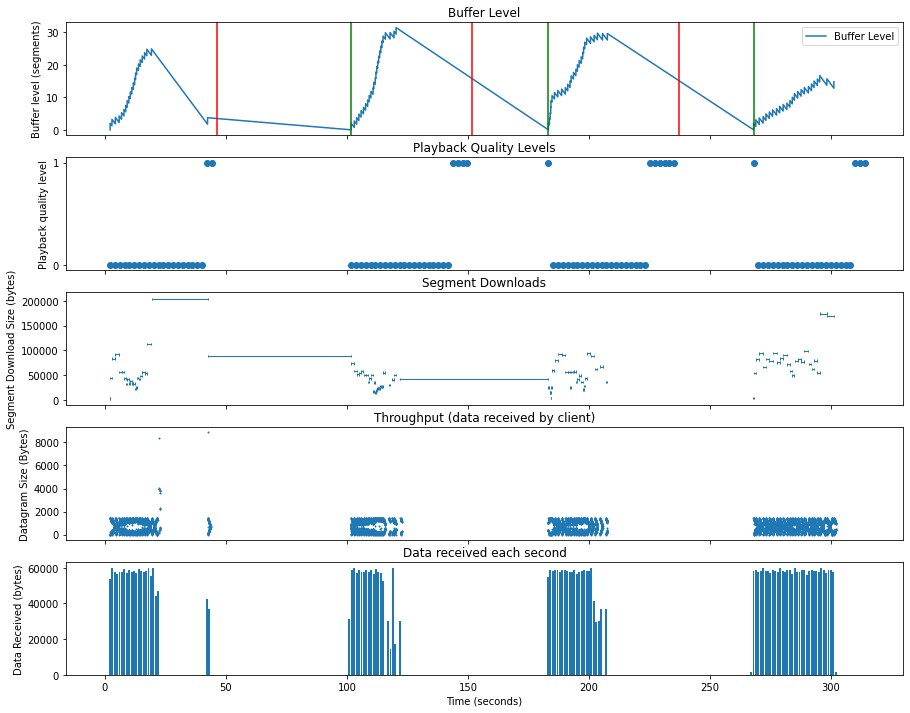



festive over QUIC @ 1Mbps (with pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 324.066


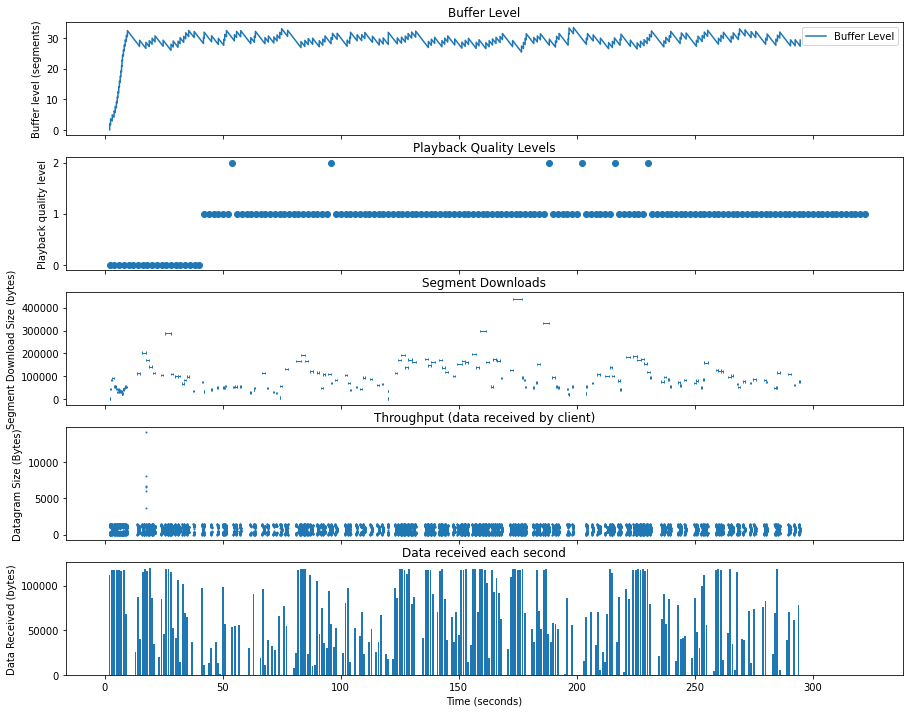



festive over QUIC @ 2Mbps (without pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 184.045


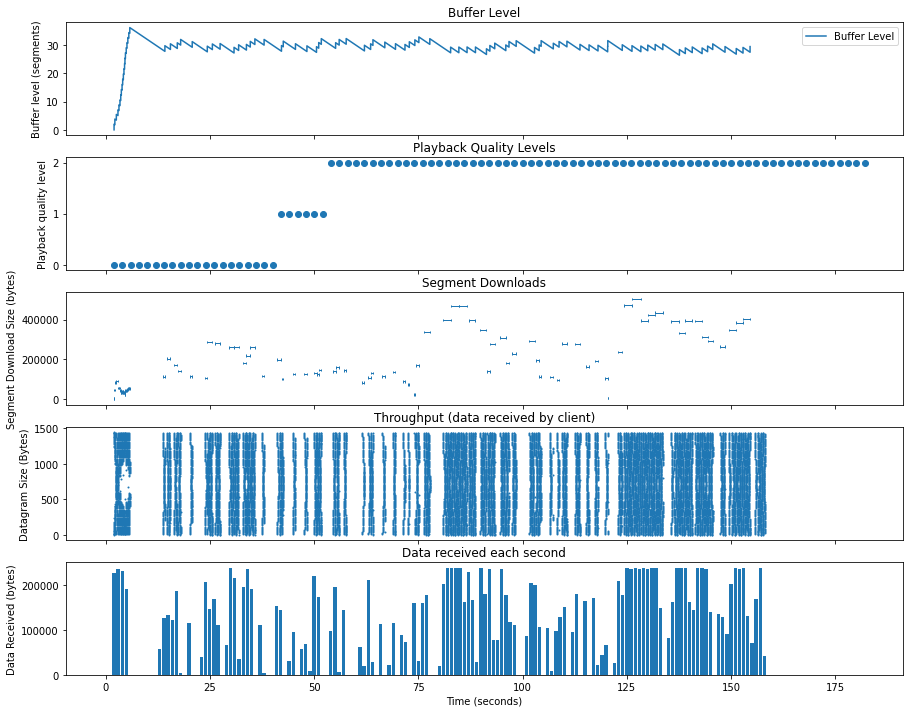



festive over QUIC @ 2Mbps (with pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 184.045


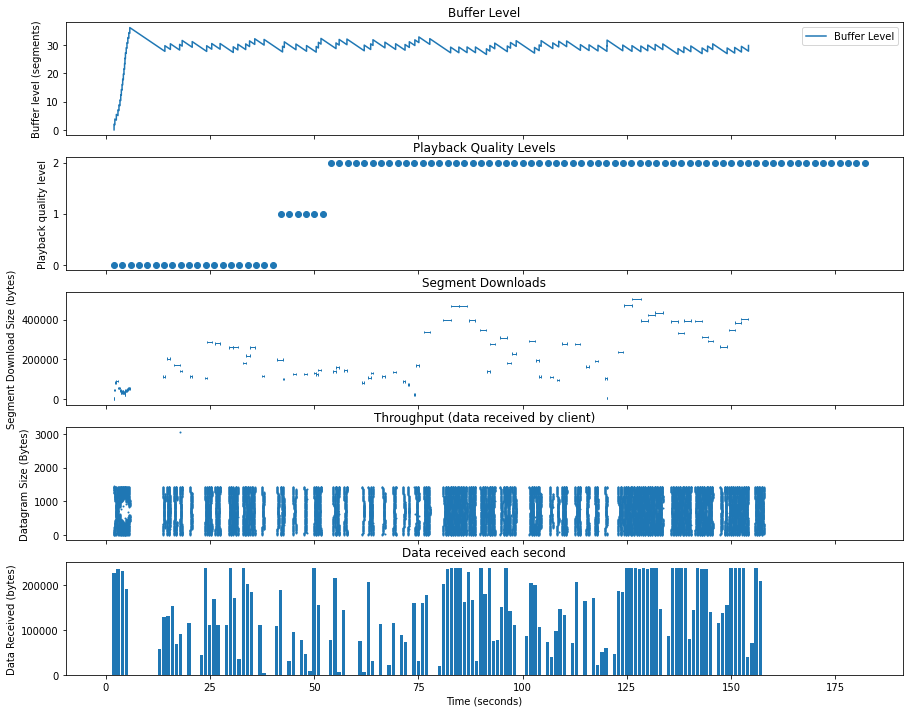



tobasco over QUIC @ 500Kbps (without pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 309.613


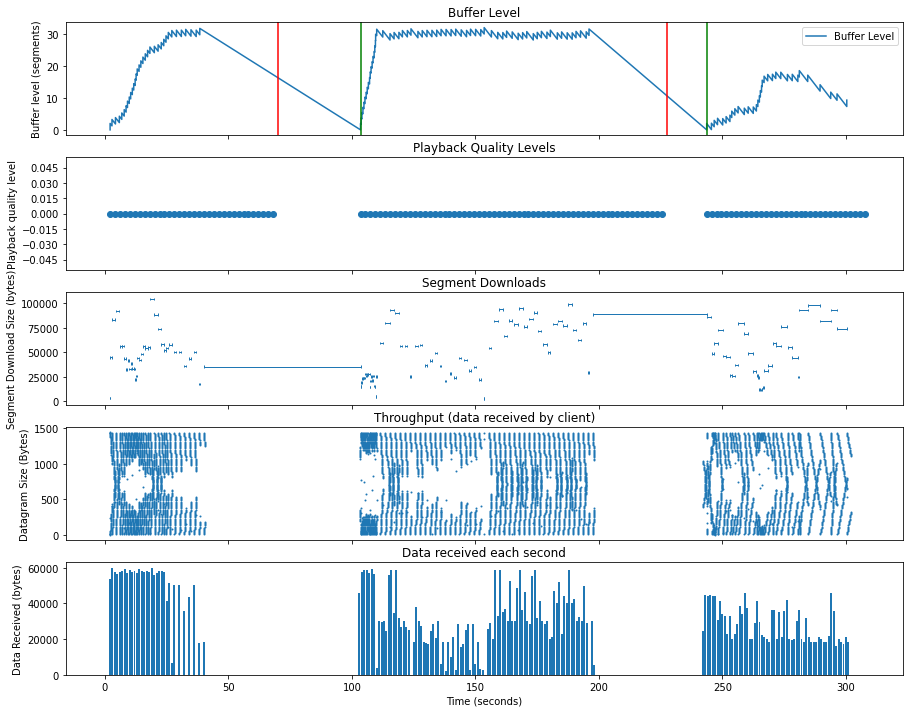



tobasco over QUIC @ 500Kbps (with pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 306.097


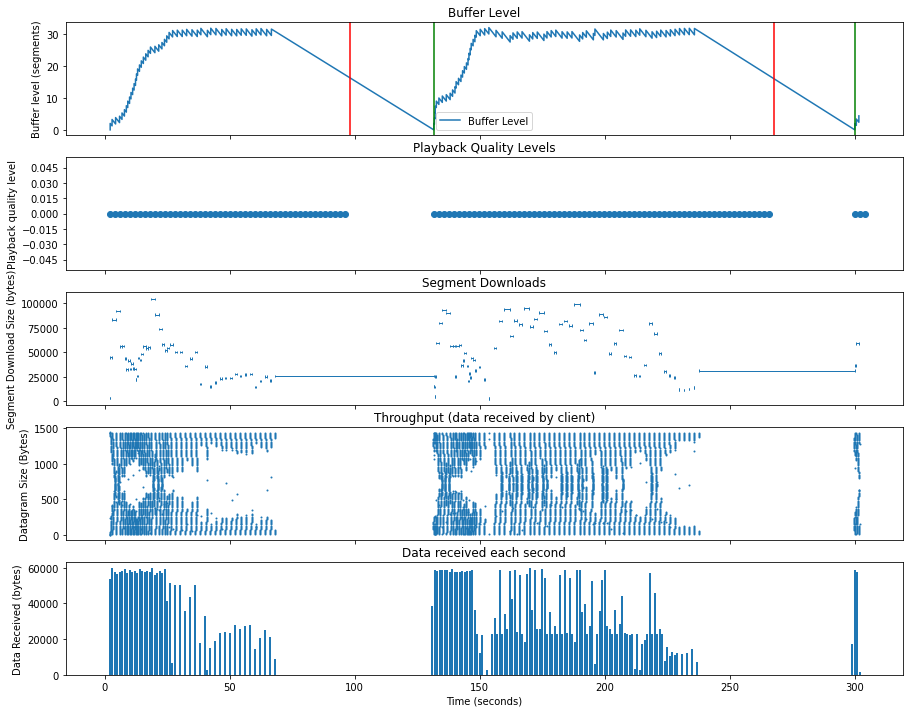



tobasco over QUIC @ 1Mbps (without pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 308.761


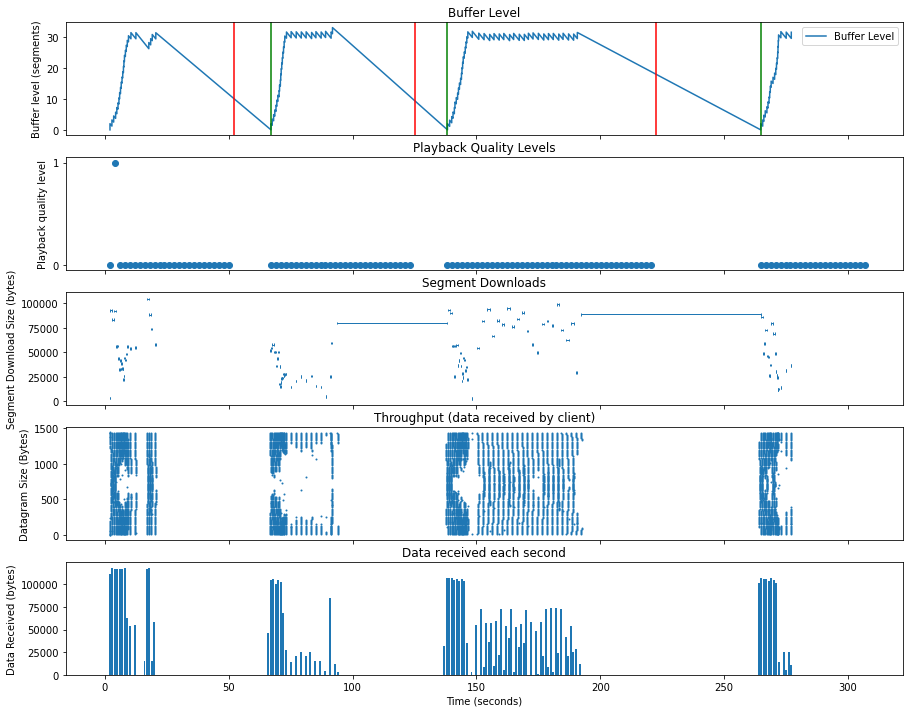



tobasco over QUIC @ 2Mbps (with pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 286.045


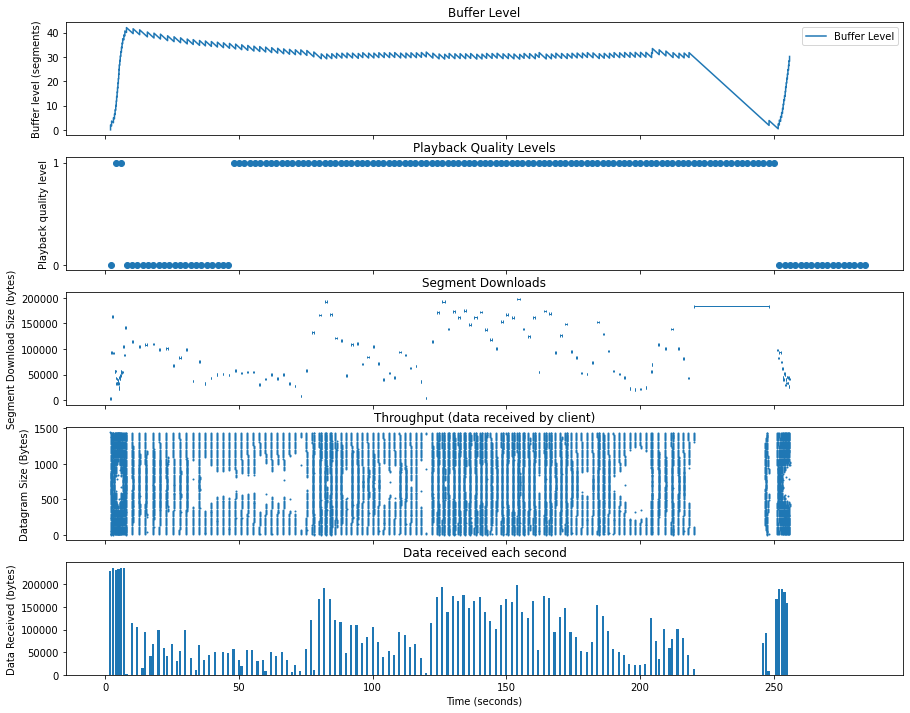



tobasco over QUIC @ 3Mbps (without pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 184.041


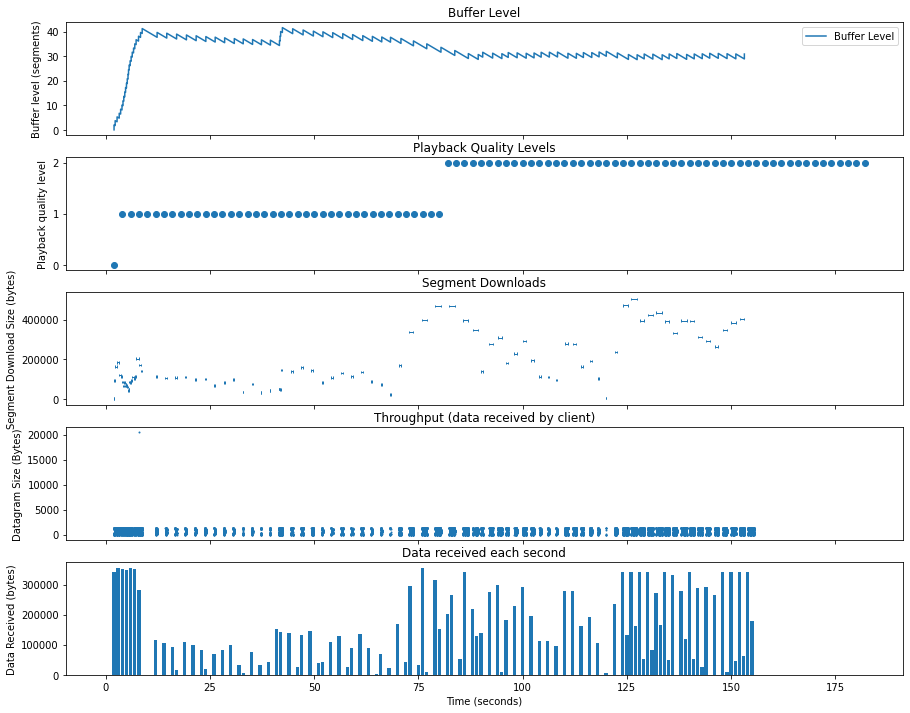



tobasco over QUIC @ 3Mbps (with pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 184.041


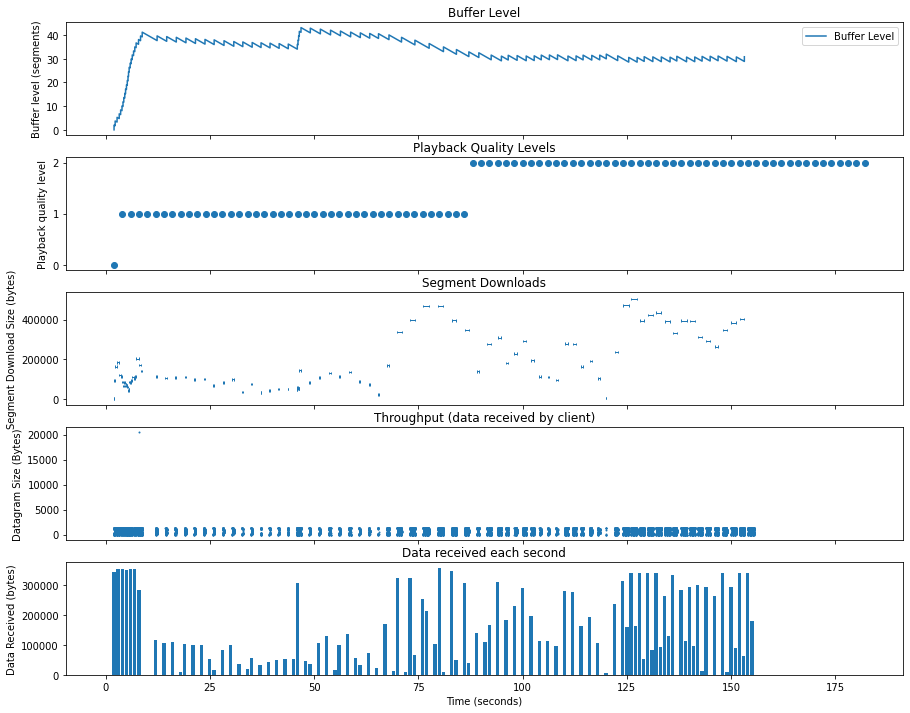



tobasco over QUIC @ 4Mbps (without pacing)
Malformed buffer underflow log. Likely that QUIC failed near time 184.038


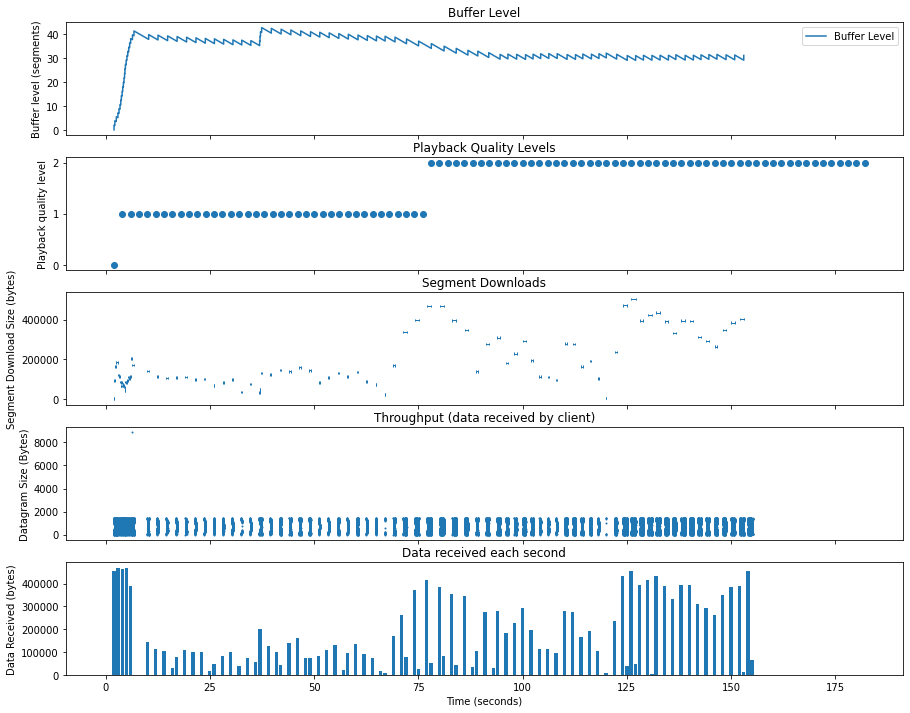

In [25]:
# Timelines for each QUIC run-through
for quicPath in findSimulations():
    quicTitle = getSimulationTitle(quicPath)
    print (quicTitle)
    graphFullTimeline(quicPath)
    print ("\n")

tobasco over QUIC @ 500Kbps (without pacing)  vs.  tobasco over TCP @ 500Kbps (without pacing)


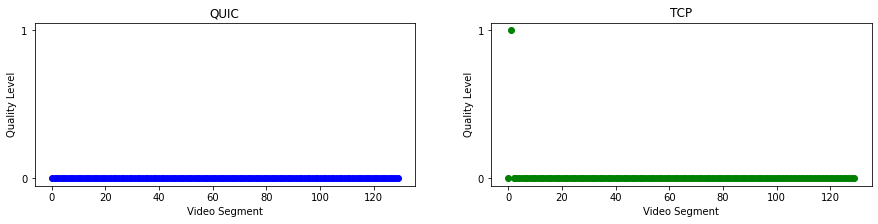

tobasco over QUIC @ 500Kbps (with pacing)  vs.  tobasco over TCP @ 500Kbps (with pacing)


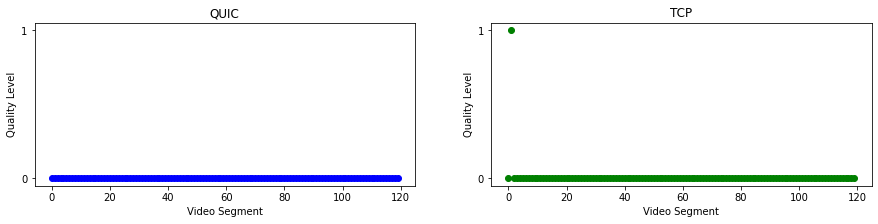

tobasco over QUIC @ 1Mbps (without pacing)  vs.  tobasco over TCP @ 1Mbps (without pacing)


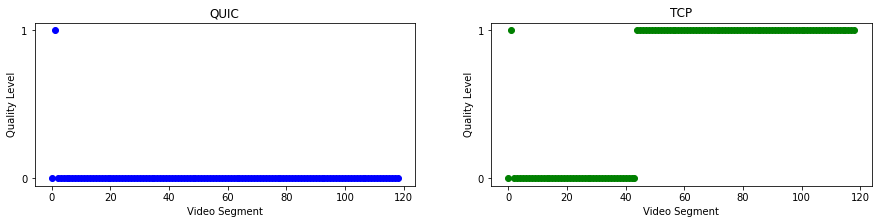

tobasco over QUIC @ 2Mbps (with pacing)  vs.  tobasco over TCP @ 2Mbps (with pacing)


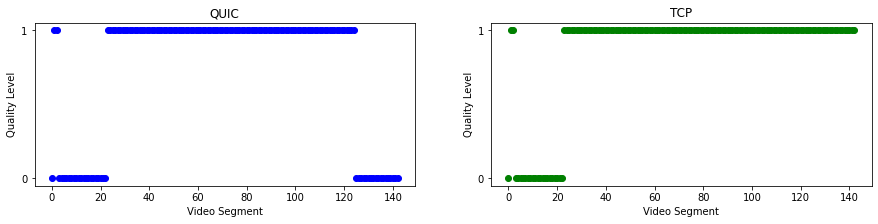

tobasco over QUIC @ 3Mbps (without pacing)  vs.  tobasco over TCP @ 3Mbps (without pacing)


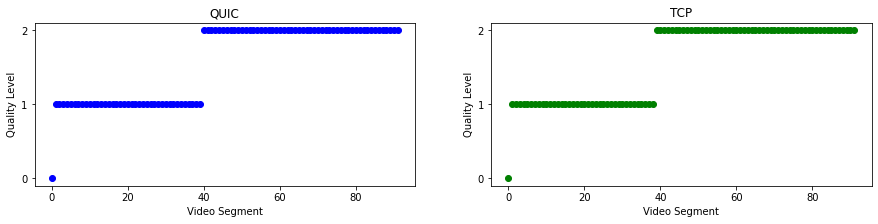

tobasco over QUIC @ 3Mbps (with pacing)  vs.  tobasco over TCP @ 3Mbps (with pacing)


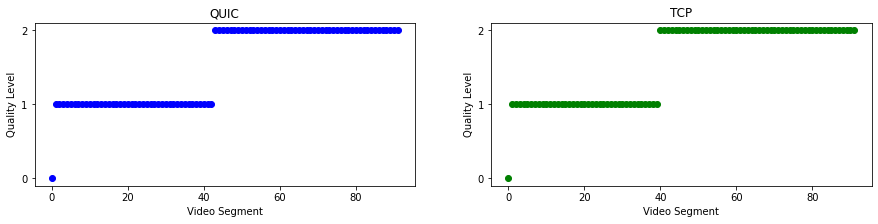

tobasco over QUIC @ 4Mbps (without pacing)  vs.  tobasco over TCP @ 4Mbps (without pacing)


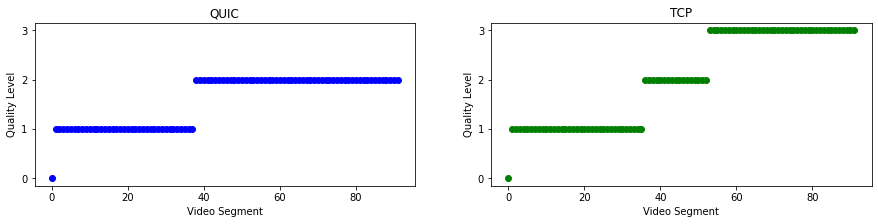

In [26]:
# Compare all the quality levels for tobasco
for (quicPath, tcpPath) in findSimulationPairs(90, quicDataDir + "tobasco\\"):
    quicTitle = getSimulationTitle(quicPath)
    tcpTitle = getSimulationTitle(tcpPath)
    
    print (quicTitle, " vs. ", tcpTitle)
    compareAdaptationLevelsSeparate (quicPath, tcpPath)

festive over QUIC @ 100Kbps (without pacing)  vs.  festive over TCP @ 100Kbps (without pacing)


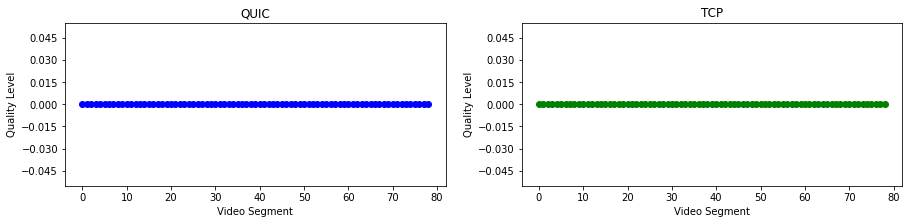

festive over QUIC @ 100Kbps (with pacing)  vs.  festive over TCP @ 100Kbps (with pacing)


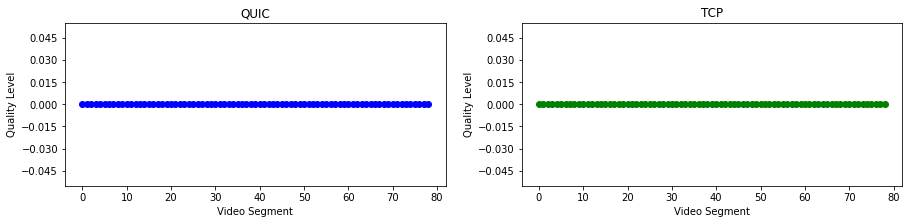

festive over QUIC @ 500Kbps (without pacing)  vs.  festive over TCP @ 500Kbps (without pacing)


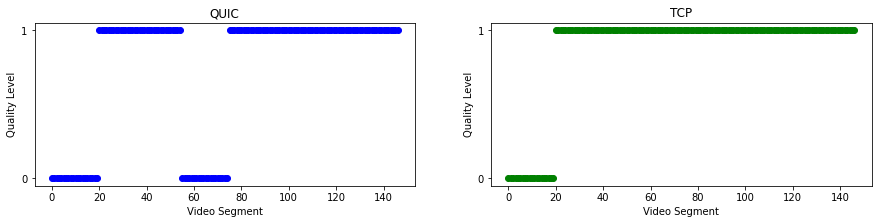

festive over QUIC @ 500Kbps (with pacing)  vs.  festive over TCP @ 500Kbps (with pacing)


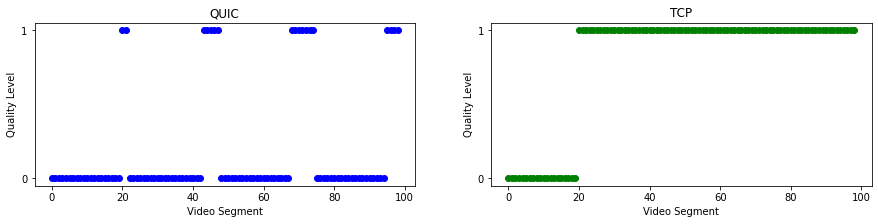

festive over QUIC @ 1Mbps (without pacing)  vs.  festive over TCP @ 1Mbps (without pacing)


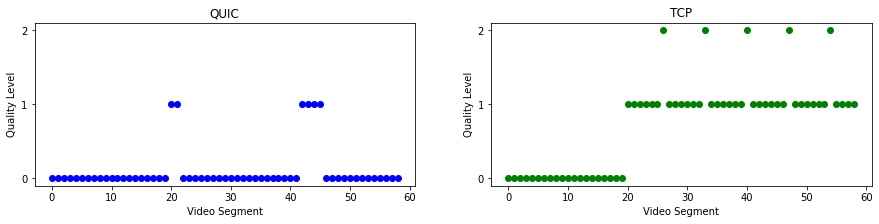

festive over QUIC @ 1Mbps (with pacing)  vs.  festive over TCP @ 1Mbps (with pacing)


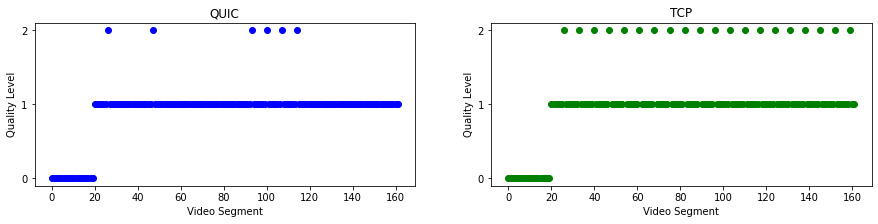

festive over QUIC @ 2Mbps (without pacing)  vs.  festive over TCP @ 2Mbps (without pacing)


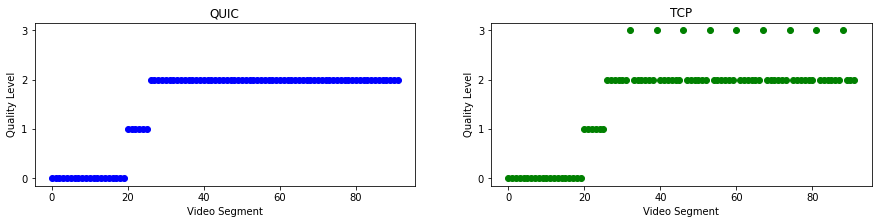

festive over QUIC @ 2Mbps (with pacing)  vs.  festive over TCP @ 2Mbps (with pacing)


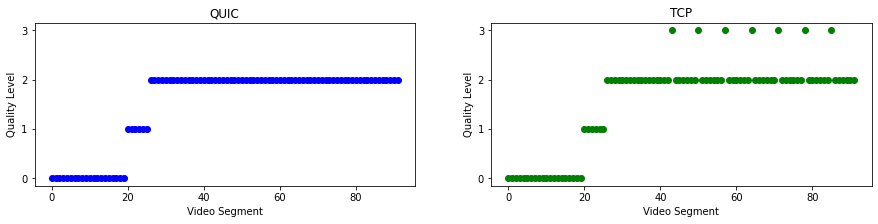

In [27]:
# Compare all the quality levels for festive
for (quicPath, tcpPath) in findSimulationPairs(50, quicDataDir + "festive\\"):
    quicTitle = getSimulationTitle(quicPath)
    tcpTitle = getSimulationTitle(tcpPath)
    
    print (quicTitle, " vs. ", tcpTitle)
    compareAdaptationLevelsSeparate (quicPath, tcpPath)